# ARMA Model

In [361]:

import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
import pandas as pd
import matplotlib
pd.set_option('display.max_rows', 2700)
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [362]:
ts=pd.read_csv("delhi_AQIclean.csv",index_col=0)
ts.head()

,pm25
date,
2018-01-01 00:00:00,423.0
2018-01-01 01:00:00,414.0
2018-01-01 02:00:00,417.0
2018-01-01 03:00:00,466.0
2018-01-01 04:00:00,470.0


In [363]:

def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

Text(0, 0.5, 'PM25')

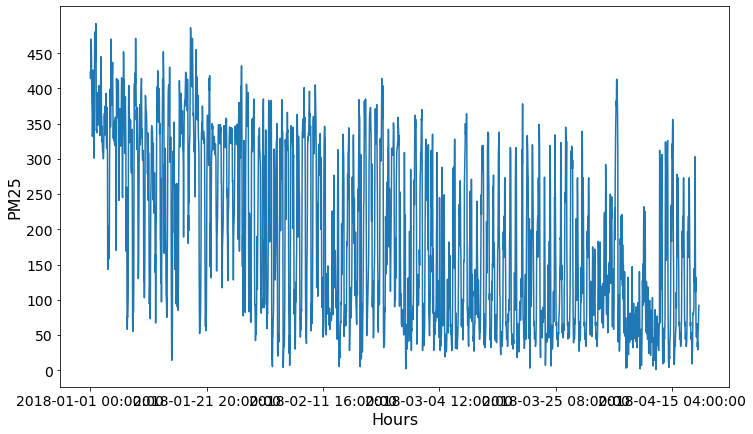

In [364]:

plt.figure(figsize=(12,7))
plt.plot(ts)

plt.xticks(np.arange(0,2700,500), fontsize=14)
plt.xlabel('Hours', fontsize=16)

plt.yticks(np.arange(0,500,50), fontsize=14)
plt.ylabel('PM25', fontsize=16)

In [365]:

mu = np.mean(ts).iloc[0]
sigma = np.std(ts).iloc[0]

norm_ts = (ts - mu) / sigma

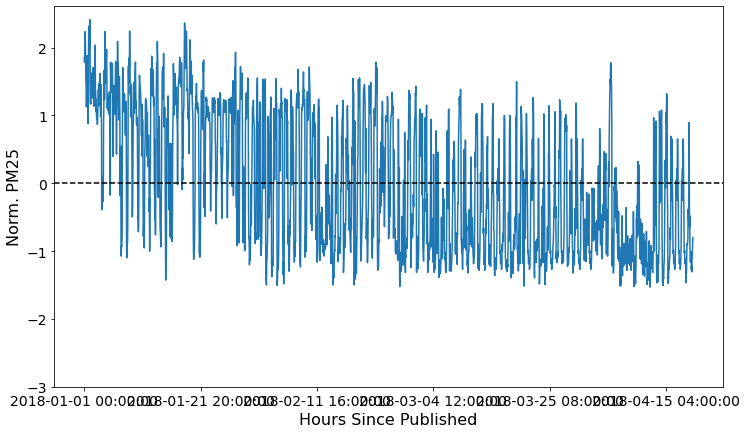

In [366]:
plt.figure(figsize=(12,7))
plt.plot(norm_ts)

plt.xticks(np.arange(0,2700,500), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(-3,3), fontsize=14)
plt.ylabel('Norm. PM25', fontsize=16)

plt.axhline(0, color='k', linestyle='--')

In [367]:
exp_ts = np.exp(norm_ts)

Text(0, 0.5, 'Exp. Norm. Views')

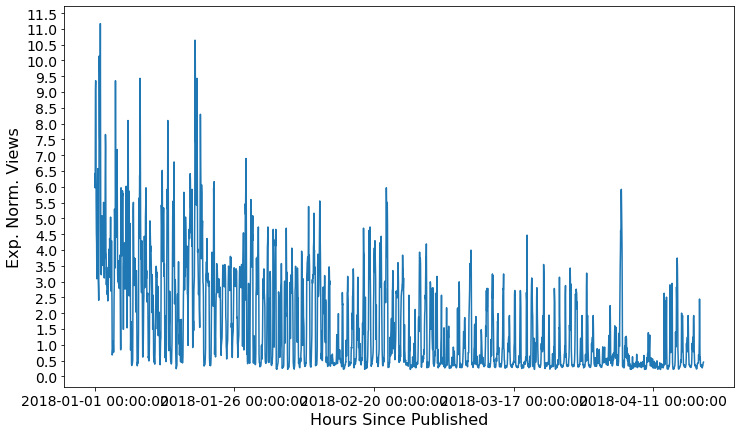

In [368]:

plt.figure(figsize=(12,7))
plt.plot(exp_ts)

plt.xticks(np.arange(0,2700,600), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(0,12,.5), fontsize=14)
plt.ylabel('Exp. Norm. Views', fontsize=16)

In [369]:
perform_adf_test(exp_ts)

ADF Statistic: -4.018245
p-value: 0.001318


In [370]:
perform_adf_test(ts)

ADF Statistic: -3.329485
p-value: 0.013611


In [371]:
diff_ts = exp_ts.diff().dropna()

In [372]:
perform_adf_test(diff_ts)

ADF Statistic: -14.466240
p-value: 0.000000


Text(0, 0.5, 'First Diff. \nExp. Norm. Views')

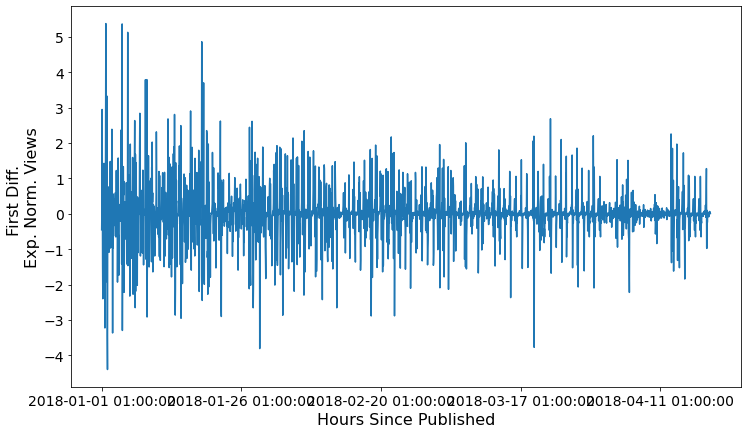

In [373]:

plt.figure(figsize=(12,7))
plt.plot(diff_ts)

plt.xticks(np.arange(0,2700,600), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(-4,6,1), fontsize=14)
plt.ylabel('First Diff. \nExp. Norm. Views', fontsize=16)


In [374]:
perform_adf_test(diff_ts)

ADF Statistic: -14.466240
p-value: 0.000000


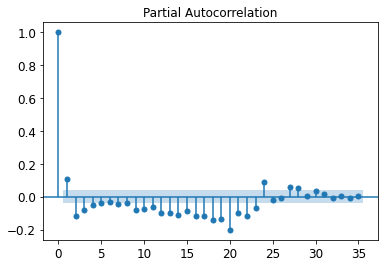

In [375]:
plot_pacf(diff_ts)
plt.show()

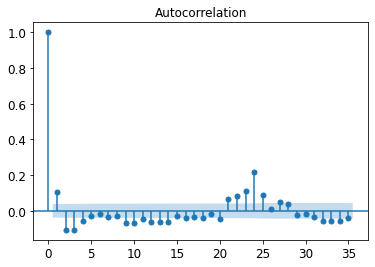

In [376]:
plot_acf(diff_ts)
plt.show()

In [377]:
diff_ts.shape

(2616, 1)

C:\Users\Umanshu Mittal\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Umanshu Mittal\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferr

plotting AR model


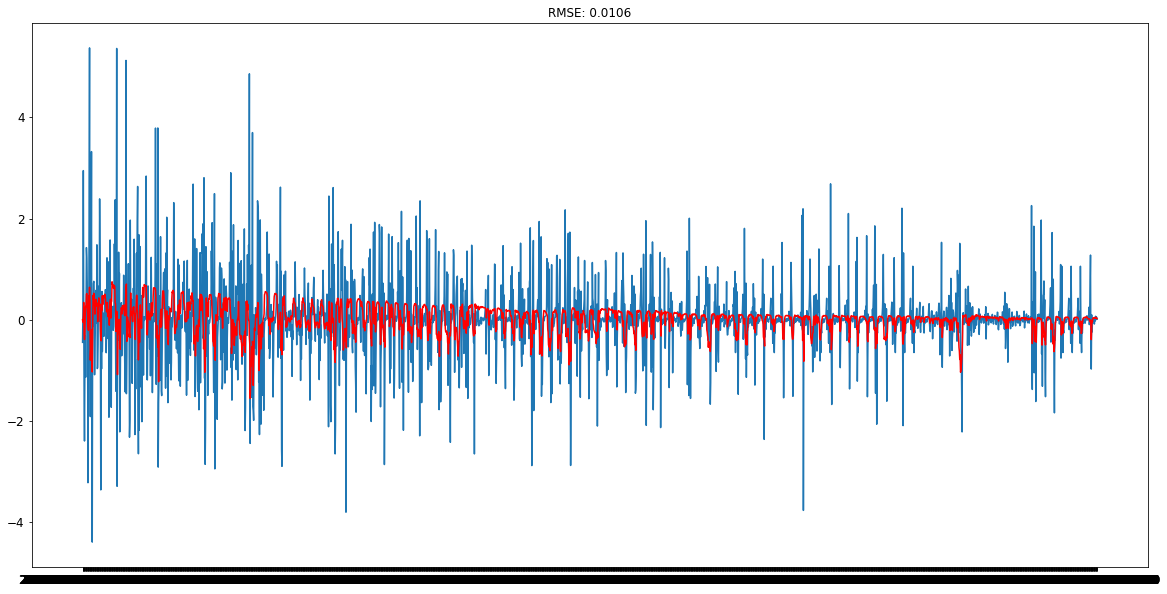

In [388]:

#create the model

from statsmodels.tsa.arima_model import ARMA

#plot ARMA model
plt.figure(figsize=(20,10))
model=ARMA(diff_ts, order=(4,1))
results_AR=model.fit(start_params=None)
plt.plot(diff_ts)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-diff_ts['pm25'])**2))
plt.title('RMSE: %.4f'% np.sqrt(np.mean(results_AR.fittedvalues-diff_ts['pm25']))**2)
#plt.title('MAPE: %.4f'% np.mean(np.abs((results_AR.fittedvalues - data_shift['pm25'])/results_AR.fittedvalues))*100)
print('plotting AR model')


In [379]:
model_fit = results_AR#model.fit()

In [380]:
prediction_info = model_fit.forecast(240)

predictions = prediction_info[0]
lower_bound = prediction_info[2][:,0]
upper_bound = prediction_info[2][:,1]

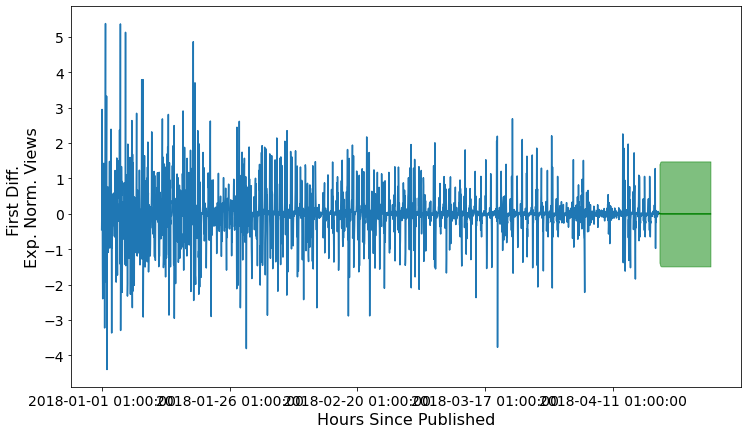

In [381]:
plt.figure(figsize=(12,7))
plt.plot(diff_ts)

plt.xticks(np.arange(0,2700,600), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(-4,6,1), fontsize=14)
plt.ylabel('First Diff. \nExp. Norm. Views', fontsize=16)

plt.plot(np.arange(len(ts)+1, len(ts)+241), predictions, color='g')
plt.fill_between(np.arange(len(ts)+1, len(ts)+241), lower_bound, upper_bound, color='g', alpha=0.5)

In [389]:
def undo_transformations(predictions, series, mu, sigma):
    first_pred = sigma*np.log(predictions[0] + np.exp((series.iloc[-1]-mu)/sigma)) + mu
    orig_predictions = [first_pred]
    
    for i in range(len(predictions[1:])):
        next_pred = sigma*np.log(predictions[i+1] + np.exp((orig_predictions[-1]-mu)/sigma)) + mu
        orig_predictions.append(next_pred)
    
    return np.array(orig_predictions).flatten()

In [390]:

orig_preds = undo_transformations(predictions, ts, mu, sigma)
orig_lower_bound = undo_transformations(lower_bound, ts, mu, sigma)
orig_upper_bound = undo_transformations(upper_bound, ts, mu, sigma)

C:\Users\Umanshu Mittal\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


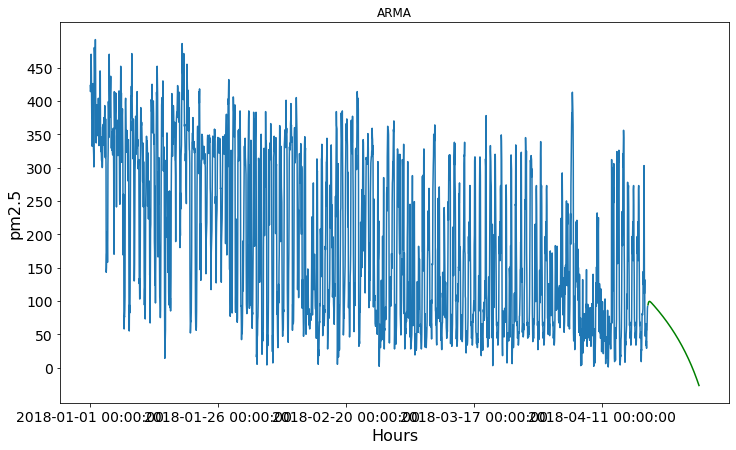

In [401]:
plt.figure(figsize=(12,7))
plt.plot(ts)

plt.xticks(np.arange(0,2700,600), fontsize=14)
plt.xlabel('Hours', fontsize=16)

plt.yticks(np.arange(0,500,50), fontsize=14)
plt.ylabel('pm2.5', fontsize=16)
plt.title('ARMA')

plt.plot(np.arange(len(ts)+1, len(ts)+241), orig_preds, color='g')
plt.fill_between(np.arange(len(ts)+1, len(ts)+241), orig_lower_bound, orig_upper_bound, color='g', alpha=1)

In [392]:
orig_preds

array([ 94.42263937,  96.26789771,  97.55310294,  98.4040572 ,
        98.93428727,  99.23009693,  99.35465474,  99.3538667 ,
        99.26111558,  99.10073186,  98.89048711,  98.64338492,
        98.36895266,  98.07417749,  97.7641871 ,  97.44274627,
        97.11261985,  96.77583855,  96.4338938 ,  96.08788074,
        95.73860318,  95.38665072,  95.03245547,  94.67633366,
        94.31851631,  93.95917174,  93.59842214,  93.23635573,
        92.87303576,  92.50850706,  92.14280094,  91.7759387 ,
        91.40793429,  91.03879623,  90.66852904,  90.29713424,
        89.9246112 ,  89.55095761,  89.17616996,  88.80024384,
        88.42317414,  88.04495521,  87.66558102,  87.28504523,
        86.90334123,  86.52046222,  86.13640123,  85.75115116,
        85.36470478,  84.97705475,  84.58819363,  84.1981139 ,
        83.80680794,  83.41426806,  83.02048646,  82.62545529,
        82.22916661,  81.83161239,  81.43278453,  81.03267485,
        80.63127509,  80.22857691,  79.82457187,  79.41

(-50.0, 400.0)

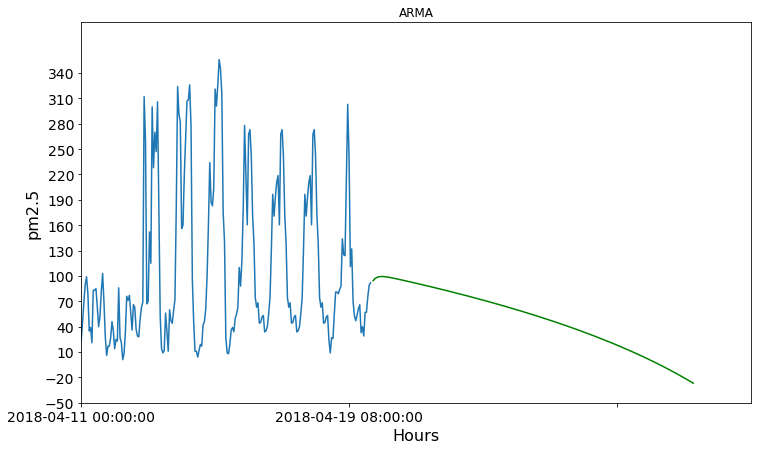

In [400]:
plt.figure(figsize=(12,7))
plt.plot(ts)

plt.xticks(np.arange(2400,2900,200), fontsize=14)
plt.xlabel('Hours', fontsize=16)

plt.yticks(np.arange(-50,370,30), fontsize=14)
plt.ylabel('pm2.5', fontsize=16)
plt.title ('ARMA')

plt.plot(np.arange(len(ts)+1, len(ts)+241), orig_preds, color='g')
plt.fill_between(np.arange(len(ts)+1, len(ts)+241), orig_lower_bound, orig_upper_bound, color='g', alpha=1)
plt.xlim(2400,2900)
plt.ylim(-50, 400)

In [396]:
orig = undo_transformations(results_AR.fittedvalues, ts, mu, sigma)

C:\Users\Umanshu Mittal\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [398]:
pd.DataFrame(orig)

array([91.63079346, 77.24199363, 97.25585774, ...,         nan,
               nan,         nan])